为了能够更加方便测试数据集合，比较各个算法模型的优劣，构建一个竞技场。目前主要支持4个平台的测试：

- arsenal
- sklearn
- spark mllib
- tensorflow


In [1]:
import os
index = os.getcwd().rfind("/notebook")
if index > 0: os.chdir(os.getcwd()[:index])

In [2]:
# Package imports
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

import eipi10.ml.neural_network as nn
import eipi10.ml.linear_model as lm
from eipi10.ml.planar_utils import *
from eipi10.ml.utils import *
from eipi10.test.testCases_v2 import *
from eipi10.ml.predictor import *
import logging

%matplotlib inline
pd.set_option('display.width', 100)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. 数据

load data/train_catvnoncat.h5
load data/test_catvnoncat.h5
(209, 64, 64, 3) (209, 1) (50, 64, 64, 3) (50, 1)
Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x_orig shape: (209, 64, 64, 3)
train_set_y_orig shape: (209, 1)
test_set_x_orig shape: (50, 64, 64, 3)
test_set_y_orig shape: (50, 1)


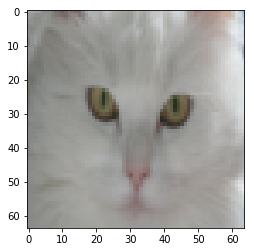

In [3]:
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# train_X_orig, train_Y_orig, test_X_orig, test_Y_orig = load_circle_dataset()
# print("train_X_orig.shape={}".format(train_X_orig.shape))
# print("train_Y_orig.shape={}".format(train_Y_orig.shape))
# print("test_X_orig.shape={}".format(test_X_orig.shape))
# print("test_Y_orig.shape={}".format(test_Y_orig.shape))

# # Visualize train data
# plt.scatter(train_X_orig.T[:, 0], train_X_orig.T[:, 1], c=train_Y_orig.T, s=40, cmap=plt.cm.Spectral)
# plt.show()
# plt.scatter(test_X_orig.T[:, 0], test_X_orig.T[:, 1], c=test_Y_orig.T, s=40, cmap=plt.cm.Spectral)

train_X_orig, train_Y_orig, test_X_orig, test_Y_orig, classes = load_image_data(
    train_data_path='data/train_catvnoncat.h5', test_data_path='data/test_catvnoncat.h5')
print(train_X_orig.shape, train_Y_orig.shape, test_X_orig.shape, test_Y_orig.shape)
plt.imshow(train_X_orig[50])

m_train = train_X_orig.shape[0]
m_test = test_X_orig.shape[0]
num_px = train_X_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x_orig shape: " + str(train_X_orig.shape))
print ("train_set_y_orig shape: " + str(train_Y_orig.shape))
print ("test_set_x_orig shape: " + str(test_X_orig.shape))
print ("test_set_y_orig shape: " + str(test_Y_orig.shape))


# 2. arsenal 

## 2.1 Logistic Regression

尝试了不同的学习率，发现在0.005时，training准确率不错，但过拟合严重

On the train set: 
Accuracy: 0.966507177033  
On the test set:  
Accuracy: 0.72  


然后调节L2的alpha值，当150时，过拟合明显缓解

INFO: Cost after epoch 0: 0.6931471806
INFO: Cost after epoch 100: 0.6338311593
INFO: Cost after epoch 200: 0.5913646750
INFO: Cost after epoch 300: 0.5734187736
INFO: Cost after epoch 400: 0.5650839660
INFO: Cost after epoch 500: 0.5609771978
INFO: Cost after epoch 600: 0.5588588052
INFO: Cost after epoch 700: 0.5577251919
INFO: Cost after epoch 800: 0.5571009471
INFO: Cost after epoch 900: 0.5567499379
INFO: Final Cost after epoch 1000: 0.5565499750


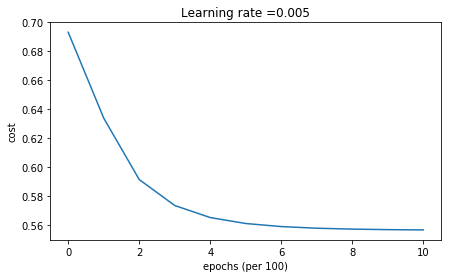

       accuracy      cost    recall  precision  specificity        f1  tp  fn  fp   tn
train  0.842105  0.466982  0.972222   0.693069     0.773723  0.809249  70   2  31  106
test   0.800000  0.508924  0.878788   0.828571     0.647059  0.852941  29   4   6   11
plot_decision_boundary only works for X which only have 2 features.


In [4]:
reload(lm)

train_X, train_Y = initialize_image_data(train_X_orig, train_Y_orig)
test_X, test_Y = initialize_image_data(test_X_orig, test_Y_orig)

model = lm.LogisticRegression(num_features=train_X.shape[0], activator=Sigmoid,   
                              regularizer=L2Regularizer(150), iterator=NumberIterator(1000), 
                              optimizer=GradientOptimizer(0.005), initializer=WeightInitializer(),
                              keep_cost_num_epoch=100)

model.fit(train_X, train_Y, print_cost=True, print_num_epoch=100)   


model.plot_costs()
ClassificationPredictor(model).print_metrics(train_X, train_Y, test_X=test_X, test_Y=test_Y)
ClassificationPredictor(model).plot_decision_boundary(train_X, train_Y)

## 2.2 神经网络



Step 1
* learning rate($\alpha$) 是首要的需要调节的参数 :  设定learning rate=0.001，epoch_times = 1000， 过拟合严重
 
On the train set:
Accuracy: 0.956937799043  
On the test set:  
Accuracy: 0.72  

Step 2
* $\beta $ for momentum. 0.9 is default  : 直接使用Adam了
* mini-batch size: 
    - mini-batch size=100, epoch_times=1000： training准确率能达到1，但过拟合更严重了,所以放弃这个修改
    
    On the train set:  
    Accuracy: 1.0  
    On the test set:  
    Accuracy: 0.66    

* hidden units：  
    - num_neurons=[train_X.shape[0], 20, 1], 减少神经元从20到10，准确率下降到65%，说明神经元的个数对模型影响比较大

Step 3
* layers  
- activators=[Relu, Sigmoid] 因为已经过拟合，就不增加层数了
* learning rate decay
    - alpha = 5 ， 设置epoch_times=500  最好的结果是：
    
    On the train set:  
    Accuracy: 1.0  
    On the test set:  
    Accuracy: 0.8  
    
* $\beta 1,  \beta 2, \epsilon$ for Adam


总体而言，和Logistic Regression的结果可以做一个基准结果相比，神经网络并没有得到更好的结果，而且过拟合严重，尝试了各种方法，效果都不佳，或许这个时候增加数据量可能是唯一的办法拉。
此外，Logistic Regression的结果可以做一个基准结果，其他算法都可以与之比较，这或许是简单算法的意义所在之一。

In [5]:

learning_rate = 0.001

#batch
epoch_times = 500
mini_batch = 0
print_num_epoch = 100
keep_cost_num_epoch = 100

#initialize
static_weight_scale=0

#regularize
alpha = 5
keep_prob = 1

#optimize
beta=0.9
beta1=0.9
beta2=0.99
epsilon=1e-8

train_X, train_Y = initialize_image_data(train_X_orig, train_Y_orig)
test_X, test_Y = initialize_image_data(test_X_orig, test_Y_orig)

num_neurons=[train_X.shape[0], 10, 1]
activators=[Relu, Sigmoid]

INFO: Cost after epoch 0: 1.4286544836
INFO: Cost after epoch 100: 0.5083222181
INFO: Cost after epoch 200: 0.3265937303
INFO: Cost after epoch 300: 0.2551049513
INFO: Cost after epoch 400: 0.2169141238
INFO: Final Cost after epoch 500: 0.1892144734


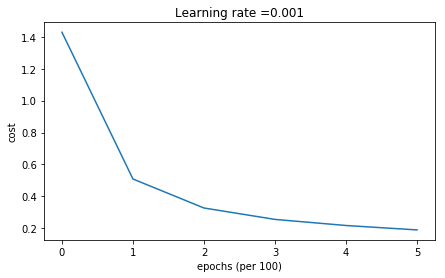

       accuracy      cost    recall  precision  specificity        f1  tp  fn  fp   tn
train      1.00  0.084133  1.000000    1.00000     1.000000  1.000000  72   0   0  137
test       0.78  0.768883  0.818182    0.84375     0.705882  0.830769  27   6   5   12
plot_decision_boundary only works for X which only have 2 features.


In [6]:
reload(nn)
model = nn.NeuralNetwork.build(
    num_neurons=num_neurons,
    activators=activators,      
    iterator=NumberIterator(epoch_times),
    initializer=HeWeightInitializer(),
    optimizer=nn.AdamOptimizer(learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=epsilon),
    keep_cost_num_epoch=keep_cost_num_epoch,
    mini_batch=mini_batch,
    regularizer=nn.L2Regularizer(alpha) ,
    keep_prob=keep_prob
)

model.fit(train_X, train_Y,  print_cost=True, print_num_epoch=print_num_epoch)
model.plot_costs()
ClassificationPredictor(model).print_metrics(train_X, train_Y, test_X=test_X, test_Y=test_Y)
ClassificationPredictor(model).plot_decision_boundary(train_X, train_Y)


# 3. sklearn

##  3.1 Logistic Regression 

不得不佩服，官方的算法收敛就是快，感觉比自己写的快几十倍。可结果怎么这么差，问题出在什么地方？

参见http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [7]:
from sklearn import linear_model
from sklearn import neighbors


train_X, train_Y = initialize_image_data(train_X_orig, train_Y_orig)
test_X, test_Y = initialize_image_data(test_X_orig, test_Y_orig)

model = linear_model.LogisticRegression(C=0.05, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logistic = model.fit(train_X.T, np.ravel(train_Y))
print(model.score(train_X.T, np.ravel(train_Y)))
print(model.score(test_X.T, np.ravel(test_Y)))


0.9856459330143541
0.72


knn = neighbors.KNeighborsClassifier()
knn = knn.fit(train_set_x.T, np.ravel(train_set_y))
print(knn.score(train_set_x.T, np.ravel(train_set_y)))
print(knn.score(test_set_x.T, np.ravel(test_set_y)))